In [ ]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf


In [ ]:
# !rm -rf original
# !rm -rf masks


In [ ]:
import gdown
# https://drive.google.com/file/d/1TDKU8xbUFApOmieVhsgCWUKVOtXFQ3cA/view?usp=sharing
!gdown --id '1TDKU8xbUFApOmieVhsgCWUKVOtXFQ3cA'

Downloading...
From: https://drive.google.com/uc?id=1TDKU8xbUFApOmieVhsgCWUKVOtXFQ3cA
To: /content/512car5.zip
100% 86.0M/86.0M [00:00<00:00, 139MB/s]


In [ ]:
# !unzip /content/data512-5.zip

!unzip /content/512car5.zip 

Archive:  /content/512car5.zip
   creating: final/
   creating: final/masks/
  inflating: final/masks/084.png     
  inflating: final/masks/085.png     
  inflating: final/masks/086.png     
  inflating: final/masks/087.png     
  inflating: final/masks/088.png     
  inflating: final/masks/089.png     
  inflating: final/masks/090.png     
  inflating: final/masks/091.png     
  inflating: final/masks/092.png     
  inflating: final/masks/093.png     
  inflating: final/masks/094.png     
  inflating: final/masks/095.png     
  inflating: final/masks/096.png     
  inflating: final/masks/097.png     
  inflating: final/masks/098.png     
  inflating: final/masks/099.png     
  inflating: final/masks/100.png     
  inflating: final/masks/101.png     
  inflating: final/masks/102.png     
  inflating: final/masks/103.png     
  inflating: final/masks/104.png     
  inflating: final/masks/105.png     
  inflating: final/masks/106.png     
  inflating: final/masks/107.png     
  inflating

In [ ]:
#Resizing images, if needed
SIZE_X = 512
SIZE_Y = 512
n_classes=5 #Number of classes for segmentation
num_images = 220  

In [ ]:
image_names = glob.glob("/content/final/original/*")

image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
print(images[0].shape)
image_dataset = np.array(images)
print(image_dataset[0].shape)
image_dataset = np.expand_dims(image_dataset, axis = 3)

(512, 512)
(512, 512)


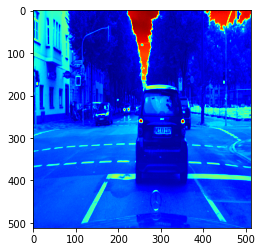

In [ ]:
image_dataset[0].shape
plt.imshow(images[2], cmap='jet')

In [ ]:
len(image_names)

220

In [ ]:
mask_names = glob.glob("/content/final/masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (220, 512, 512, 1)
Mask data shape is:  (220, 512, 512)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4])

In [ ]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(220, 512, 512, 1)


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can a/lso normalize or scale using MinMax scaler

In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.02, random_state=1)


In [ ]:
# max(y_train[0][0])

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [ ]:
print(y_train_cat.shape)

(172, 512, 512, 5)


In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 512, 512, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 512, 512, 64  256        ['conv2d_57[0][0]']              
 ormalization)                  )                                                     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 2, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=True)

Epoch 1/50
86/86 [==============================] - 186s 2s/step - loss: 0.0661 - mean_io_u: 0.4000 - val_loss: 0.2597 - val_mean_io_u: 0.4674
Epoch 2/50
86/86 [==============================] - 163s 2s/step - loss: 0.0524 - mean_io_u: 0.4000 - val_loss: 0.2575 - val_mean_io_u: 0.4720
Epoch 3/50
86/86 [==============================] - 163s 2s/step - loss: 0.0452 - mean_io_u: 0.4000 - val_loss: 0.2563 - val_mean_io_u: 0.4811
Epoch 4/50
 6/86 [=>............................] - ETA: 2:11 - loss: 0.0416 - mean_io_u: 0.4000

KeyboardInterrupt: ignored

In [ ]:
#Save the model for future use
model.save('./modelfilenew.hdf5')

In [ ]:
!cp /content/modelfilenew.hdf5 /content/drive/MyDrive/cardata

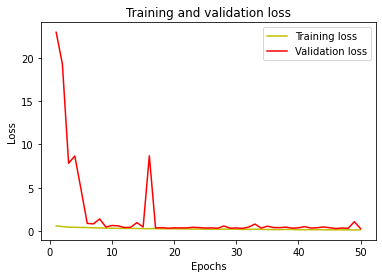

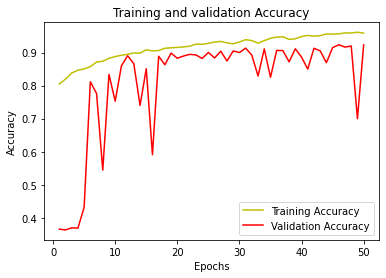

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

        #Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/cardata/modelfilenew.hdf5", compile=False)

In [ ]:
y_pred=model.predict(X_val)

In [ ]:
y_pred.shape

(4, 512, 512, 5)

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(4, 512, 512)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_val[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5310291


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)



[[0.00000e+00 6.60000e+01 0.00000e+00 4.20000e+01 1.49900e+03]
 [0.00000e+00 4.16130e+04 9.91000e+02 3.34000e+02 5.10400e+03]
 [0.00000e+00 4.15000e+02 3.77947e+05 5.19200e+03 3.24100e+03]
 [0.00000e+00 6.34000e+02 4.87900e+03 1.38470e+04 5.22600e+03]
 [0.00000e+00 1.69360e+04 1.69180e+04 2.93580e+04 5.24334e+05]]
IoU for class1 is:  0.0
IoU for class2 is:  0.94461215
IoU for class3 is:  0.97052824
IoU for class4 is:  0.55547976


In [ ]:
X_val=X_test
y_val=y_test

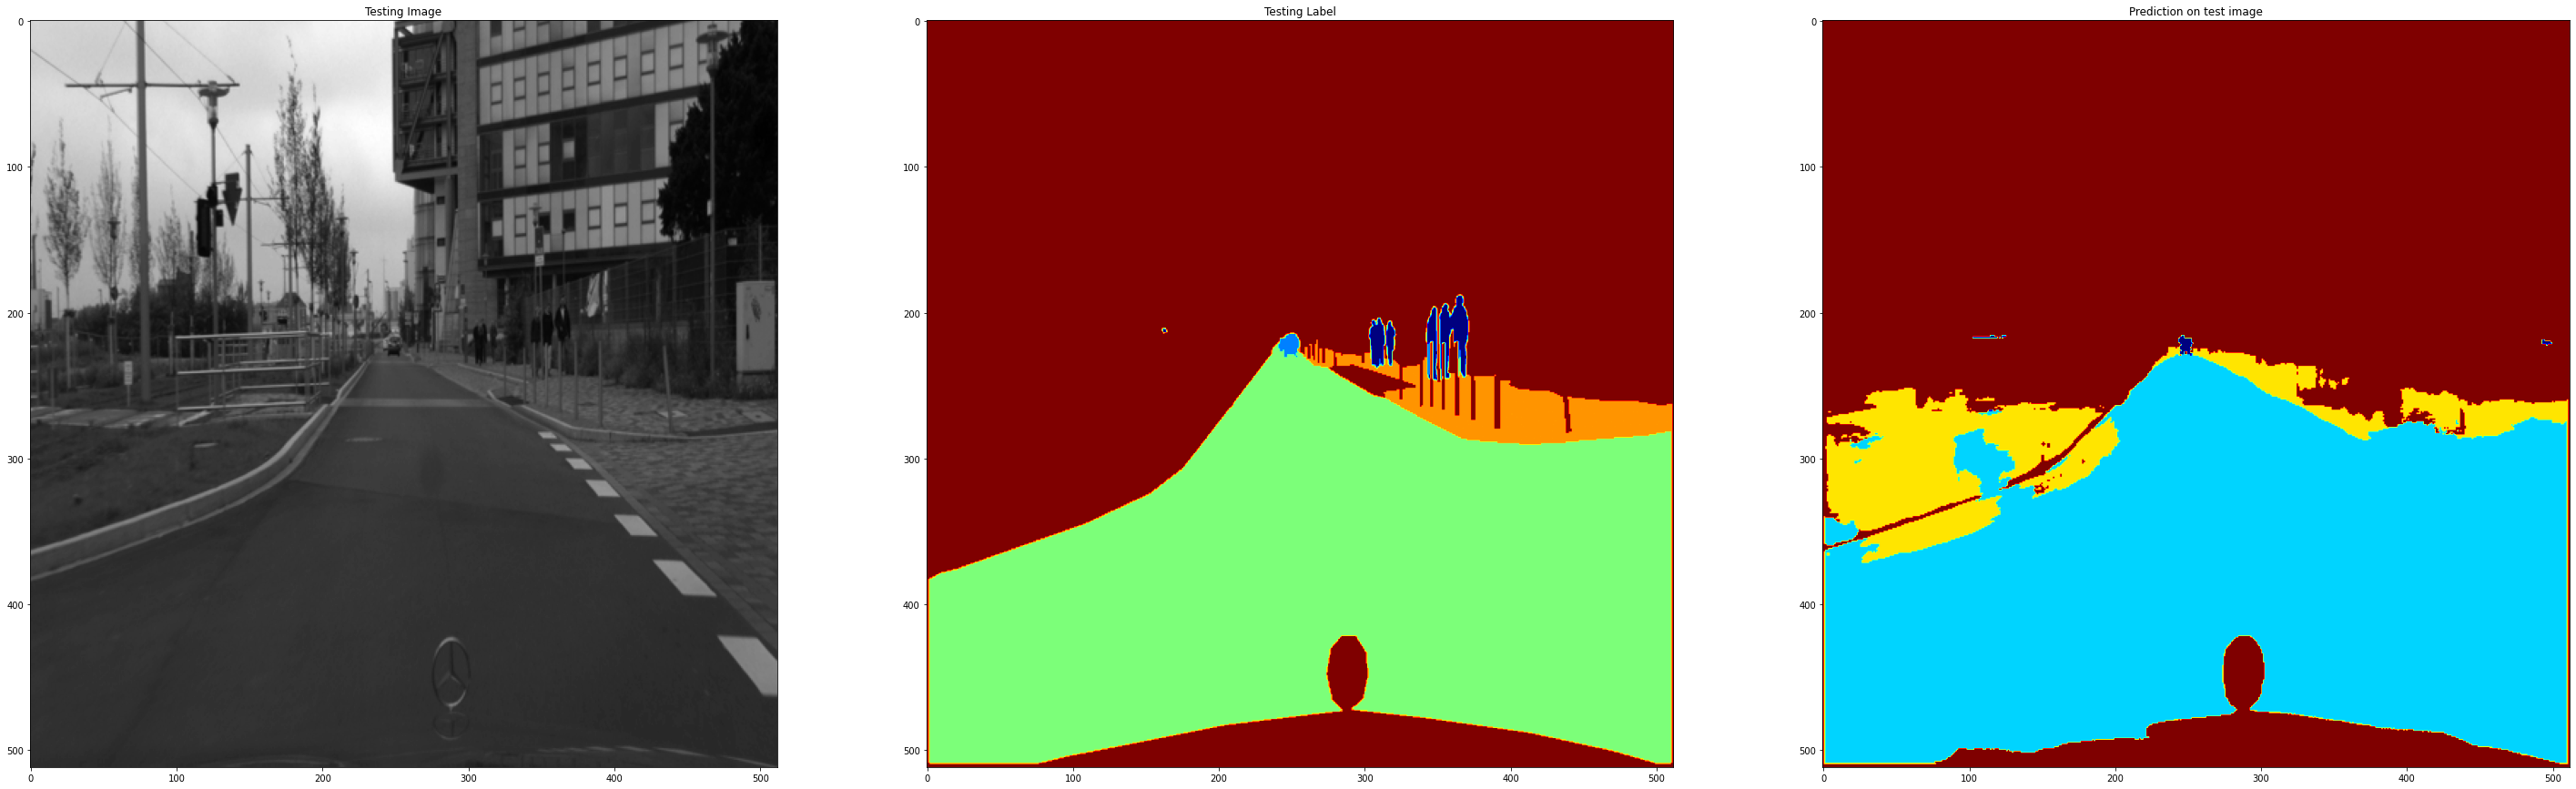

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, 5)
test_img = X_val[test_img_number]
ground_truth=y_val[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(50, 50))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()